In [154]:
#librosa
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd

#keras
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

import pandas as pd

from datetime import datetime

import os

import warnings
warnings.simplefilter('ignore')

In [155]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Default GPU Device: /device:GPU:0
Num GPUs Available:  1


2022-12-04 00:16:00.627393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:16:00.627640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:16:00.627746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:16:00.627887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:16:00.627992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## EDA and dataset curation

In [156]:
base_path = "/home/rishav/repo/ml/speaker-recognizer"
model_path = os.path.join(base_path, "models")

In [157]:
!ls ../data/shivam_shukla/

/usr/bin/bash: /home/rishav/anaconda3/envs/speaker-recognizer-391/lib/libtinfo.so.6: no version information available (required by /usr/bin/bash)
TestingAudio  TrainingAudio


**Visualize sound**

In [158]:
sample_file = os.path.join(base_path, "data/shivam_shukla/TrainingAudio/Aadiksha-007/Aadiksha_1.wav")

In [159]:
ipd.Audio(filename=sample_file)

**Plot sound**

Text(0.5, 1.0, 'Sample hindi audio')

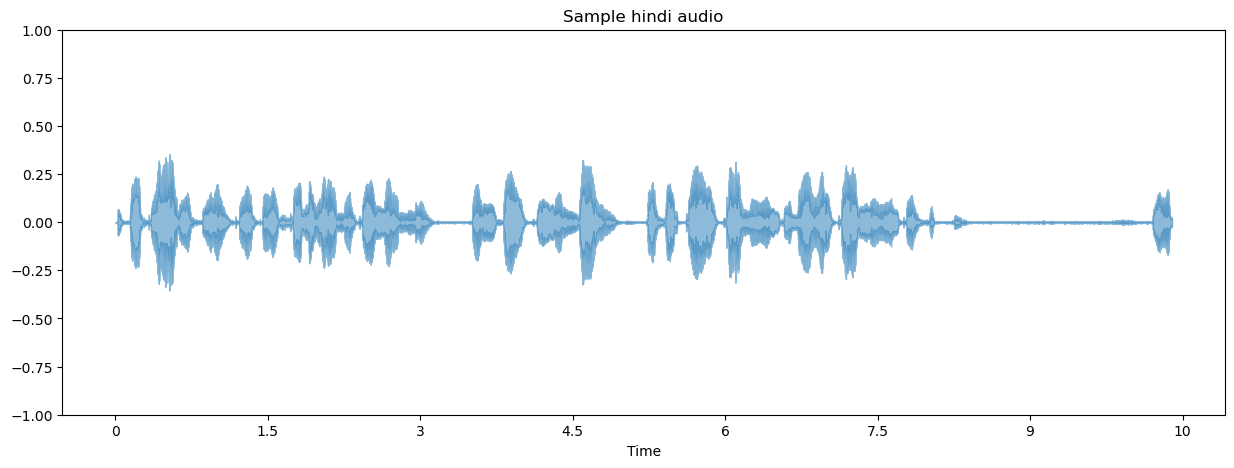

In [160]:
sample_audio, sr = librosa.load(sample_file)
plt.figure(figsize=(15, 17))

plt.subplot(3, 1, 1)
librosa.display.waveshow(sample_audio, alpha=0.5)
plt.ylim((-1, 1))
plt.title("Sample hindi audio")

In [161]:
data_dir = "../data/shivam_shukla/"

In [162]:
def get_file_path_and_speaker(data_dir):
    speaker_name_and_ids = {}
    speaker_counter = 0
    file_path_and_speaker = {}
    for root, dirs, files in os.walk(data_dir):
        path = root.split(os.sep)
        for file in files:
            speaker, file_path = file.split("_")[0].lower(), os.path.join(*path, file)            
            if speaker not in speaker_name_and_ids:
                speaker_counter += 1
                speaker_name_and_ids[speaker] = speaker_counter
            
            speaker_id = speaker_name_and_ids[speaker]
            file_path_and_speaker[file_path] = speaker_id
            
    
    speaker_df = pd.DataFrame.from_dict(file_path_and_speaker, orient='index')
    speaker_df['file_path'] = speaker_df.index
    speaker_df.reset_index(drop=True, inplace=True)
    speaker_df.rename(columns={0: 'speaker_id'}, inplace=True)
    
    return speaker_df, speaker_name_and_ids

    
speaker_df, speaker_name_and_ids = get_file_path_and_speaker(data_dir)

In [163]:
print(f'''No. of speakers in the dataset : {len(speaker_df['speaker_id'].unique())}''')

No. of speakers in the dataset : 104


In [164]:
speaker_df[:2]

,speaker_id,file_path
0,1,../data/shivam_shukla/TrainingAudio/Nandini-01...
1,1,../data/shivam_shukla/TrainingAudio/Nandini-01...


In [165]:
len(speaker_name_and_ids)

104

## Features extraction

### MFCCs + resemblyzer embeddings + ecapa-tdnn embeddings


In [166]:
# def extract_classical_features(file_path):
#     print(f'''File Path : {file_path}''')
#     # Loads the audio file as a floating point time series and assigns the default sample rate
#     # Sample rate is set to 22050 by default
#     X, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    
#     # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
#     mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    
#     # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
#     stft = np.abs(librosa.stft(X))
    
#     # Computes a chromagram from a waveform or power spectrogram.
#     chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    
#     # Computes a mel-scaled spectrogram.
#     mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    
#     # Computes spectral contrast
#     contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    
#     # Computes the tonal centroid features (tonnetz)
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
#     sr=sample_rate).T,axis=0)
#     return np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

In [167]:
# ran as a separate scipt

# encoder = VoiceEncoder()
# classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

# def extract_features(file_path):
#     print(f'''File Path : {file_path}''')
#     # Loads the audio file as a floating point time series and assigns the default sample rate
#     # Sample rate is set to 22050 by default
#     X, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    
#     # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
#     mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    
#     # resemblyzer embedding
#     wav = preprocess_wav(file_path)
#     resemblyzer_embedding = encoder.embed_utterance(wav)
    
#     # ecapa-tdnn embedding
#     ecapa_embeddings = classifier.encode_batch(signal)
#     ecapa_embeddings = np.array(embeddings)[0][0]
    
#     return np.concatenate((mfccs, resemblyzer_embedding, ecapa_embeddings))

In [168]:
speaker_df = pd.read_pickle(os.path.join(base_path, "embeddings/embedding_resem_ecapa_mfcc_2022-11-11.pkl"))

In [169]:
speaker_df = speaker_df.dropna()

In [170]:
speaker_df.head()

,speaker_id,file_path,features
0,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,"[0.0, 0.03816767, 0.003265001, 0.0, 0.07449556..."
1,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,"[0.0, 0.0, 0.0, 0.0, 0.0034749918, 0.0, 0.0, 0..."
2,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,"[0.0, 0.00027992934, 0.0, 0.0, 0.0006586461, 0..."
3,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,"[0.0012314628, 0.0070201936, 0.0, 0.0, 8.30900..."
4,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,"[0.0, 0.0128953755, 0.0, 0.0, 0.088847354, 0.0..."


In [171]:
print(f''' Length of features : {len(speaker_df['features'][0])} ''')

 Length of features : 488 


In [172]:
len(speaker_df), speaker_df[:2]

(596,
    speaker_id                                          file_path  \
 0           1  /home/rishav/repo/ml/speaker-recognizer/data/s...   
 1           1  /home/rishav/repo/ml/speaker-recognizer/data/s...   
 
                                             features  
 0  [0.0, 0.03816767, 0.003265001, 0.0, 0.07449556...  
 1  [0.0, 0.0, 0.0, 0.0, 0.0034749918, 0.0, 0.0, 0...  )

In [173]:
len(speaker_df['speaker_id'].unique())

104

In [174]:
single_speaker_df = speaker_df.groupby('speaker_id').agg({'file_path' : 'count'}).sort_values(by='file_path')
single_speaker_df.head()

,file_path
speaker_id,
104,1
102,1
103,1
23,1
85,2


In [175]:
# speaker with only one files
speakers_with_1_file = single_speaker_df[single_speaker_df['file_path'] == 1].index.values.tolist()

In [176]:
speaker_df  = speaker_df[~speaker_df['speaker_id'].isin(speakers_with_1_file)]
len(speaker_df['speaker_id'].unique())

100

In [177]:
len(speaker_df)

592

In [178]:
speaker_df.head()

,speaker_id,file_path,features
0,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,"[0.0, 0.03816767, 0.003265001, 0.0, 0.07449556..."
1,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,"[0.0, 0.0, 0.0, 0.0, 0.0034749918, 0.0, 0.0, 0..."
2,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,"[0.0, 0.00027992934, 0.0, 0.0, 0.0006586461, 0..."
3,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,"[0.0012314628, 0.0070201936, 0.0, 0.0, 8.30900..."
4,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,"[0.0, 0.0128953755, 0.0, 0.0, 0.088847354, 0.0..."


In [179]:
def split_list_col_to_multiple_cols(df, list_col_name):
    df = df.reset_index(drop=True)
    out_cols = [f'{list_col_name}_{col}' for col in range(len(df[list_col_name][0]))]

    split_df = pd.DataFrame(df[list_col_name].tolist(), columns=out_cols)
    df = pd.concat([df, split_df], axis=1)
    df = df.drop(columns=[list_col_name])
    return df

In [180]:
speaker_df = split_list_col_to_multiple_cols(speaker_df, 'features')



The most efficient way:

1. Select last n columns

df1 = df.iloc[:,-n:]

2. Exclude last n columns

df1 = df.iloc[:,:-n]

In [181]:
speaker_df.iloc[:,:-40]

,speaker_id,file_path,features_0,features_1,features_2,features_3,features_4,features_5,features_6,features_7,...,features_438,features_439,features_440,features_441,features_442,features_443,features_444,features_445,features_446,features_447
0,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000000,0.038168,0.003265,0.0,0.074496,0.000000,0.000000,0.177207,...,-40.388069,30.764111,-15.533382,-14.586903,-15.513224,35.252651,5.378547,-32.499428,16.683060,-12.361774
1,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000000,0.000000,0.000000,0.0,0.003475,0.000000,0.000000,0.158346,...,-27.943604,27.352983,-24.945629,-4.164711,-0.493050,29.570770,6.497405,-33.178360,18.063915,1.195673
2,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000000,0.000280,0.000000,0.0,0.000659,0.000000,0.000000,0.148074,...,-35.985458,47.141502,-12.699745,-0.128119,-15.459205,24.743750,6.386729,-5.139894,20.117447,-1.742788
3,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.001231,0.007020,0.000000,0.0,0.000083,0.000000,0.000000,0.226556,...,-33.336811,35.875111,-12.067087,9.968670,-16.323866,19.469984,-2.602828,-34.456802,36.486046,8.103794
4,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000000,0.012895,0.000000,0.0,0.088847,0.000000,0.000000,0.116784,...,-25.645863,41.756905,-5.615845,2.291059,-5.420635,16.600758,14.598194,-7.431079,15.726495,-6.899206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,77,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000321,0.000000,0.008555,0.0,0.093250,0.066367,0.000000,0.000000,...,-24.957041,6.441969,-27.504892,5.487303,-21.573629,-12.361586,-8.315006,-7.009865,8.885789,-8.935936
588,74,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000000,0.008889,0.000000,0.0,0.106668,0.012380,0.000000,0.045773,...,-34.686062,33.779060,-12.014564,-21.477661,-11.424354,28.731649,23.649712,-11.839587,9.012902,-19.326515
589,62,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000000,0.000000,0.043075,0.0,0.000000,0.073513,0.014433,0.020480,...,-26.129795,48.973774,20.424252,11.296093,-18.073118,-19.426039,42.009819,15.791553,29.899265,-1.273551
590,8,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.011412,0.008393,0.011204,0.0,0.058247,0.011653,0.000000,0.036595,...,-24.788488,10.766528,-2.969445,36.957798,-2.428898,-41.187592,27.453339,17.105347,18.482222,-14.253113


In [182]:
# speaker_df = speaker_df.drop(columns=['file_path'])
speaker_df.head()

,speaker_id,file_path,features_0,features_1,features_2,features_3,features_4,features_5,features_6,features_7,...,features_478,features_479,features_480,features_481,features_482,features_483,features_484,features_485,features_486,features_487
0,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000000,0.038168,0.003265,0.0,0.074496,0.0,0.0,0.177207,...,3.249623,0.587230,2.005002,4.577084,3.384436,3.876786,2.840175,1.289016,1.376126,0.549010
1,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000000,0.000000,0.000000,0.0,0.003475,0.0,0.0,0.158346,...,-0.163925,-0.593613,2.417464,-0.932581,3.137921,4.629621,1.257883,1.780391,-0.018711,0.297658
2,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000000,0.000280,0.000000,0.0,0.000659,0.0,0.0,0.148074,...,1.737427,0.215508,2.876651,2.241221,1.997901,2.039349,1.866133,1.412809,0.731161,1.714615
3,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.001231,0.007020,0.000000,0.0,0.000083,0.0,0.0,0.226556,...,6.195522,1.974960,1.643825,3.411064,4.456521,3.514908,3.550544,0.372875,1.908104,-0.419111
4,1,/home/rishav/repo/ml/speaker-recognizer/data/s...,0.000000,0.012895,0.000000,0.0,0.088847,0.0,0.0,0.116784,...,3.572222,1.837779,-0.388122,2.850527,2.062762,3.459944,3.264947,1.740958,-0.414755,1.740045


In [183]:
speaker_df[speaker_df['speaker_id'].isna()]

,speaker_id,file_path,features_0,features_1,features_2,features_3,features_4,features_5,features_6,features_7,...,features_478,features_479,features_480,features_481,features_482,features_483,features_484,features_485,features_486,features_487


In [184]:
speaker_df_copy = speaker_df.copy()
speaker_df_copy = speaker_df_copy.drop(columns=['file_path'])
speaker_df_copy.shape

(592, 489)

In [185]:
mfcc_features = speaker_df_copy.iloc[:,-40:]
mfcc_features.shape

(592, 40)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(speaker_df_copy,
                                                  speaker_df_copy['speaker_id'],
                                                  stratify=speaker_df_copy['speaker_id'],
                                                  test_size=0.20,
                                                  random_state=11)

In [187]:
X_test_df = X_test.copy()

In [188]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((473, 489), (119, 489), (473,), (119,))

In [189]:
len(X_train['speaker_id'].unique()), len(X_test['speaker_id'].unique())

(100, 100)

In [190]:
X_train.head()

,speaker_id,features_0,features_1,features_2,features_3,features_4,features_5,features_6,features_7,features_8,...,features_478,features_479,features_480,features_481,features_482,features_483,features_484,features_485,features_486,features_487
390,80,0.000400,0.000000,0.000000,0.0,0.116201,0.018205,0.000000,0.034723,0.038656,...,2.673580,-0.005607,-0.329364,-3.879424,-0.913047,-0.819869,-0.983953,-3.589724,-3.072891,-4.364663
189,40,0.009108,0.015504,0.000000,0.0,0.064046,0.000000,0.075285,0.089774,0.036073,...,-2.719269,-1.028034,-3.695537,-1.136740,-3.000577,-4.934022,-3.071886,-4.699590,-2.002640,-3.982381
286,60,0.024768,0.143490,0.000000,0.0,0.000000,0.000000,0.000000,0.027786,0.000000,...,-1.735381,-2.117471,-2.400496,-3.310796,-3.113306,-0.869774,-3.332922,-3.267820,-0.368774,-0.456047
504,59,0.000000,0.000000,0.018159,0.0,0.017501,0.023992,0.000000,0.000000,0.014633,...,-0.032288,-0.902452,4.310391,0.688187,-0.606640,1.119674,-2.133713,-0.323609,-4.037243,-3.891122
42,9,0.080120,0.000000,0.025537,0.0,0.000046,0.010970,0.000000,0.000000,0.068280,...,0.579753,1.925481,5.628007,4.154262,3.949396,3.279026,1.064938,-0.515670,-1.577143,-1.230226


In [191]:
y_train.head()

390    80
189    40
286    60
504    59
42      9
Name: speaker_id, dtype: int64

In [192]:
def get_cols_with_prefix(df, prefix):
    return [col for col in df.columns if col.startswith(prefix)]
    
x_cols = get_cols_with_prefix(X_train, 'features')    
X_train = X_train[x_cols]
X_test = X_test[x_cols]

**Normalize MFCC features**

In [193]:
ss = StandardScaler()

In [194]:
cols = ['features_'+ str(counter) for counter in range(0, 488)]
X_train[cols] = ss.fit_transform(X_train[cols])
X_test[cols] = ss.transform(X_test[cols])

In [195]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [196]:
X_train.min().min(), X_train.max().max(), X_test.min().min(), X_test.max().max()

(-4.266976833343506, 16.438819885253906, -4.337993621826172, 20.75739097595215)

In [197]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((473, 488), (119, 488), (473, 100), (119, 100))

In [198]:
X_train = X_train.values
X_test = X_test.values

In [199]:
print(pd.DataFrame(X_train).isna().sum().sum())
print(pd.DataFrame(X_test).isna().sum().sum())
print(pd.DataFrame(y_train).isna().sum().sum())
print(pd.DataFrame(y_test).isna().sum().sum())

0
0
0
0


In [200]:
model = Sequential()
input_feature_size = 488
n_classes = 100

# initializer = tf.keras.initializers.GlorotNormal()
model.add(Dense(128, input_shape=(input_feature_size,), activation = 'relu'))
model.add(BatchNormalization())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.20))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(n_classes, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

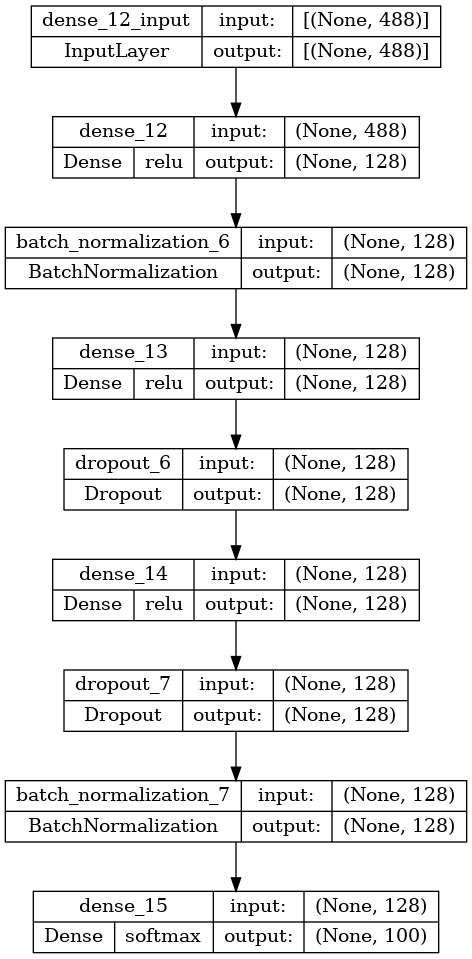

In [201]:
from keras.utils import plot_model
dot_img_file = 'model_ecapa.png'
plot_model(model, to_file=dot_img_file, show_shapes=True, show_layer_activations=True)

In [202]:
history = model.fit(X_train, y_train, batch_size=128, epochs=2000, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

Epoch 1/2000
4/4 [==============================] - 1s 98ms/step - loss: 5.0259 - accuracy: 0.0169 - val_loss: 4.5517 - val_accuracy: 0.0084
Epoch 2/2000
4/4 [==============================] - 0s 9ms/step - loss: 4.5290 - accuracy: 0.0423 - val_loss: 4.3644 - val_accuracy: 0.0420
Epoch 3/2000
4/4 [==============================] - 0s 8ms/step - loss: 4.1485 - accuracy: 0.0634 - val_loss: 4.1772 - val_accuracy: 0.1176
Epoch 4/2000
4/4 [==============================] - 0s 9ms/step - loss: 3.7694 - accuracy: 0.1586 - val_loss: 3.9939 - val_accuracy: 0.2185
Epoch 5/2000
4/4 [==============================] - 0s 7ms/step - loss: 3.5573 - accuracy: 0.2114 - val_loss: 3.8201 - val_accuracy: 0.2941
Epoch 6/2000
4/4 [==============================] - 0s 8ms/step - loss: 3.2454 - accuracy: 0.2685 - val_loss: 3.6594 - val_accuracy: 0.3697
Epoch 7/2000
4/4 [==============================] - 0s 8ms/step - loss: 2.9673 - accuracy: 0.3975 - val_loss: 3.5080 - val_accuracy: 0.4538
Epoch 8/2000
4/4 [=

4/4 [==============================] - 0s 7ms/step - loss: 0.2744 - accuracy: 0.9958 - val_loss: 0.2036 - val_accuracy: 0.9832
Epoch 60/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.2512 - accuracy: 0.9915 - val_loss: 0.1932 - val_accuracy: 0.9832
Epoch 61/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.2748 - accuracy: 0.9937 - val_loss: 0.1849 - val_accuracy: 0.9832
Epoch 62/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.2537 - accuracy: 0.9873 - val_loss: 0.1790 - val_accuracy: 0.9832
Epoch 63/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.2229 - accuracy: 0.9937 - val_loss: 0.1715 - val_accuracy: 0.9832
Epoch 64/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.2163 - accuracy: 0.9958 - val_loss: 0.1632 - val_accuracy: 0.9832
Epoch 65/2000
4/4 [==============================] - 0s 8ms/step - loss: 0.2324 - accuracy: 0.9958 - val_loss: 0.1563 - val_accuracy: 0.9832
Epoch 66/2000
4/4 [========

4/4 [==============================] - 0s 8ms/step - loss: 0.0943 - accuracy: 0.9958 - val_loss: 0.0681 - val_accuracy: 0.9832
Epoch 118/2000
4/4 [==============================] - 0s 8ms/step - loss: 0.0876 - accuracy: 0.9979 - val_loss: 0.0675 - val_accuracy: 0.9832
Epoch 119/2000
4/4 [==============================] - 0s 8ms/step - loss: 0.0887 - accuracy: 0.9979 - val_loss: 0.0669 - val_accuracy: 0.9832
Epoch 120/2000
4/4 [==============================] - 0s 9ms/step - loss: 0.0971 - accuracy: 0.9979 - val_loss: 0.0658 - val_accuracy: 0.9832
Epoch 121/2000
4/4 [==============================] - 0s 8ms/step - loss: 0.0911 - accuracy: 0.9979 - val_loss: 0.0653 - val_accuracy: 0.9832
Epoch 122/2000
4/4 [==============================] - 0s 9ms/step - loss: 0.0798 - accuracy: 0.9979 - val_loss: 0.0639 - val_accuracy: 0.9832
Epoch 123/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.0873 - accuracy: 0.9958 - val_loss: 0.0615 - val_accuracy: 0.9832
Epoch 124/2000
4/4 [=

Epoch 175/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.0562 - accuracy: 1.0000 - val_loss: 0.0348 - val_accuracy: 1.0000
Epoch 176/2000
4/4 [==============================] - 0s 8ms/step - loss: 0.0400 - accuracy: 1.0000 - val_loss: 0.0350 - val_accuracy: 1.0000
Epoch 177/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.0458 - accuracy: 1.0000 - val_loss: 0.0352 - val_accuracy: 0.9916
Epoch 178/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.0577 - accuracy: 0.9937 - val_loss: 0.0352 - val_accuracy: 0.9916
Epoch 179/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.0481 - accuracy: 1.0000 - val_loss: 0.0350 - val_accuracy: 0.9916
Epoch 180/2000
4/4 [==============================] - 0s 8ms/step - loss: 0.0507 - accuracy: 0.9958 - val_loss: 0.0346 - val_accuracy: 0.9916
Epoch 181/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.0591 - accuracy: 0.9979 - val_loss: 0.0348 - val_accuracy: 0.9916
Epoch 

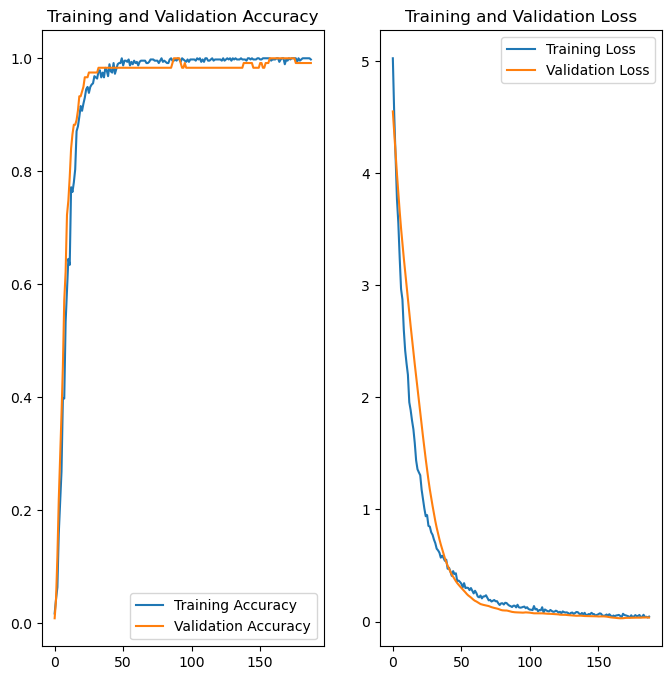

In [204]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(188)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
X_test.shape, y_test.shape

In [ ]:
predict_x = model.predict(X_test) 
classes_predicted = np.argmax(predict_x, axis=1)

In [ ]:
true_classes = np.argmax(y_test, axis=1)

In [ ]:
pred_df = pd.DataFrame({"true_label" : true_classes, "predicted_label" : classes_predicted})

In [ ]:
matched_df = pred_df[pred_df['true_label'] == pred_df['predicted_label']]
print(f'Accuracy : {len(matched_df)/ len(pred_df)}')

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from itertools import cycle

In [ ]:
macro_roc_auc_ovo = roc_auc_score(y_test, predict_x, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, predict_x, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, predict_x, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, predict_x, multi_class="ovr", average="weighted"
)

print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(set(true_classes))):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predict_x[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predict_x.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
np.mean(list(roc_auc.values()))

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

# 
# colors = cycle(["aqua", "darkorange", "cornflowerblue"])
# for i, color in zip(range(n_classes), colors):
#    plt.plot(
#        fpr[i],
#        tpr[i],
#        color=color,
#        lw=lw,
#        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
#    )
# 

lw = 2
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()